# <img src="https://img.icons8.com/dusk/64/000000/mind-map.png" style="height:50px;display:inline"> CS 236756 - Technion - Intro to Machine Learning
---
#### Tal Daniel

## Tutorial 10 - Expectation Maximization
---

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Demonstrations](#-Demonstrations)
    * [K-Means](#--K-Means)
    * [Gaussian Mixture Models (GMM)](#-Gaussian-Mixture-Models-(GMMs))
* [Expectation-Maximization](#-Expectation-Maximization-(EM))
    * [Formalization](#-Formalization)
* [Gaussian Mixture Models (GMM)](#-Gaussian-Mixture-Models-(GMMs)-as-EM)
* [Bernoulli Mixture Model (BMM)](#-Bernoulli-Mixture-Models-(BMMs)-as-EM)
* [K-Means as "Hard GMM"](#-Relation-to-K-Means:-K-Means-as-"Hard-GMM")
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## <img src="https://img.icons8.com/clouds/100/000000/classroom.png" style="height:50px;display:inline"> Demonstrations
---
* Definitions:
    * **Hard Clustering** - clusters do not overlap, an element either belongs to a cluster or does not.
    * **Soft Clustering** - clusters may overlap. Strength of association between clusters and instances (confidence level).

### <img src="https://img.icons8.com/dusk/64/000000/k.png" style="height:50px;display:inline">  K-Means
---
* K-means clustering is one of the simplest and most popular unsupervised machine learning algorithms.
    * Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labeled, outcomes.


* The objective of K-means: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.
    * This is also called **hard clustering** as the association of a data point to a cluster is definitive, that is, it belongs to one cluster only and cannot be included in other cluster.
    
* A cluster refers to a collection of data points aggregated together because of certain similarities.

* Illustration: <img src="./assets/tut_10_kmeans.jpg" style="height:300px">
    * *E* and *M* stand for the **E-step** and **M-step**

* Animation: <img src="./assets/tut_10_kmeans_anim.gif" style="height:300px">

* **Algorithm**: Starts with a first group of randomly selected centroids, which are used as the starting points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids. It halts creating and optimizing clusters when either:
    * The centroids have stabilized — there is no change in their values because the clustering has been successful.
    * The defined number of iterations has been achieved.

Explanations and example from <a href="https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1">Understanding K-Means Clustering in Machine Learning - towardsdatascience.com</a>

In [2]:
# k-means example
from sklearn.cluster import KMeans
def generate_random_data():
    # generate random data
    X = -2 * np.random.rand(100,2)
    X[50:100, :] = 1 + 2 * np.random.rand(50,2)
    return X

def plot_data(X):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b')
    ax.grid()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("some random data")

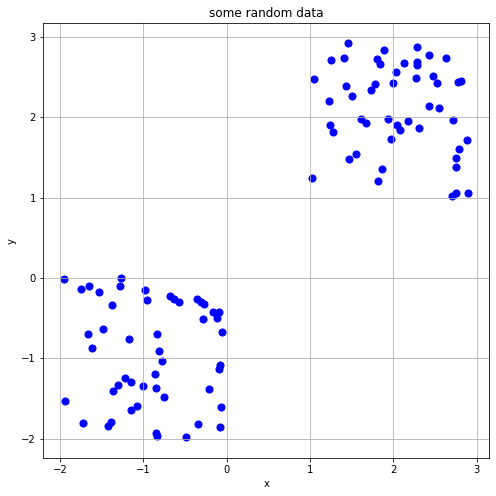

In [3]:
X = generate_random_data()
plot_data(X)

In [4]:
def run_plot_kmeans(X):
    k_mean = KMeans(n_clusters=2)
    k_mean.fit(X)
    print(k_mean)
    # plot the centroids
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b', label="data")
    ax.scatter(k_mean.cluster_centers_[0][0], k_mean.cluster_centers_[0][1], s=200, c='g', marker='s', label="center 1")
    ax.scatter(k_mean.cluster_centers_[1][0], k_mean.cluster_centers_[1][1], s=200, c='r', marker='s', label="center 2")
    ax.grid()
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("some random data")

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


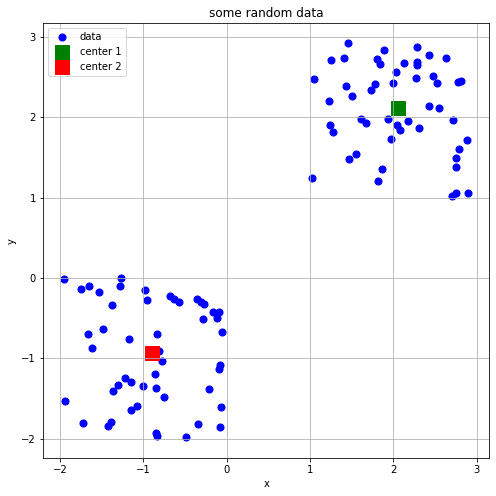

In [5]:
run_plot_kmeans(X)

### <img src="https://img.icons8.com/color/96/000000/normal-distribution-histogram.png" style="height:50px;display:inline"> Gaussian Mixture Models (GMMs)
---
* A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 
    * That is, we consider a family of models, $p_{\theta}(x)$, which is a weighted sum of $k$ Gaussian functions, where each Gaussian can have different mean and co-variance matrix.
* One can think of mixture models as generalizing k-means clustering to incorporate information about the co-variance structure of the data as well as the centers of the latent Gaussians.

* The parameters of the model are the mean, co-variance and weight of each Gaussian, which are unknown and will be learned by the EM algorithm.
    * The parameters: $\theta = \{\alpha_l, \mu_l, \Sigma_l \}_{l=1}^k$ ($\alpha$ is the weight vector).
    * In other words- "with probability $\alpha_l$ draw the sample from $l^{th}$ Gaussian".
* **Goal**: *Soft clustering* the data under the assumption that it is generated by a mixture of Gaussians.
    * The optimization method is called Expectation Maximization (EM) and will be used to achieve this goal.

* Illustration: <img src="./assets/tut_10_gmm.jpg" style="height:300px">

* Animation: <img src="./assets/tut_10_gmm_anim.gif" style="height:300px">
* Example: the following example is taken from <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html">The Python Data Science Handbook</a>

In [8]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
def generate_blobs():
    X, y_true = make_blobs(n_samples=400, centers=4,
                           cluster_std=0.60, random_state=0)
    X = X[:, ::-1] # flip axes for better plotting
    return X

def plot_blobs(X):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis')
    ax.grid()

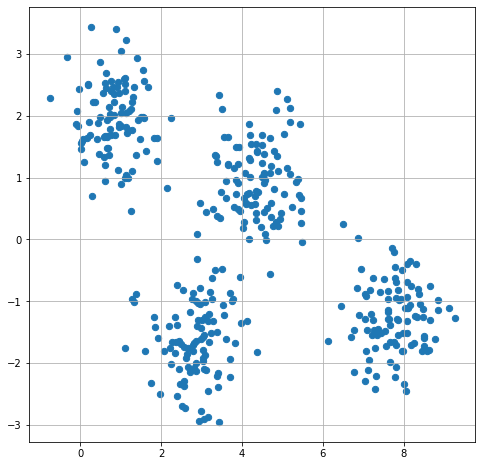

In [9]:
X = generate_blobs()
plot_blobs(X)

In [12]:
# some helper functions for plotting
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [13]:
def run_plot_gmm(X):
    gmm = GaussianMixture(n_components=4, random_state=42)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.grid()
    plot_gmm(gmm, X, ax=ax)

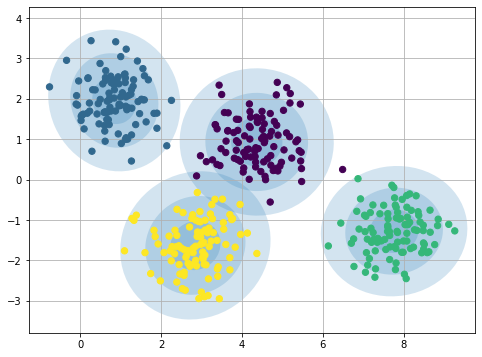

In [14]:
run_plot_gmm(X)

## <img src="https://img.icons8.com/dusk/64/000000/zoom-to-extents.png" style="height:50px;display:inline"> Expectation Maximization (EM)
---
* Probabilistic method for **soft clustering**.
    * The "soft" version of K-means
* Assumes a probabilistic model of clusters that allows computing $Pr(c_j|x)$ for each cluster $c_j$ for a given example $x$.
    * If we had known for each data instance from what distribution it came from, we could have used a parametric estimation.
* We introduce *unobservable (latent)* variables which indicate source distribution.
* We run an iterative process:
    * Estimate latent variables from the data and the *current* estimation of distribution parameters.
    * Use current values of latent variables to refine parameter estimation.

### <img src="https://img.icons8.com/cotton/50/000000/tie.png" style="height:50px;display:inline"> Formalization
---
* Log likelihood for a mixture model (under the *i.i.d* assumption): $$ \mathcal{L}(X|\Theta) =  \log \prod_{i=1}^n Pr(x_i|\Theta) = \sum_{i=1}^n\log \sum_{j=1}^k Pr(x_i|C_j;\Theta)Pr(C_j;\Theta)$$
* Assume *latent* variables $z$, which when known make the optimization simpler:
    * **Complete** likelihood, $ \mathcal{L}_c (X,Z|\Theta) $, in terms of $x$ and $z$
    * **Incomplete** likelihood, $\mathcal{L}(X|\Theta)$, in terms of $x$

* The **incomplete** likelihood: $$\mathcal{L}(X|\Theta) = \log \left(\prod_{i=1}^n Pr(x_i \mid \theta)\right) = \sum_{i=1}^n \log \left(\sum_{j=1}^K Pr(x_i \mid z_i=j, \theta) Pr(z_i=j \mid \theta) \right)  $$
    * Calculating the log-likelihood of the observed data is **hard**!
        * This is because of the sum inside of the logarithm - the derivative w.r.t. to the parameters and equivalenting to 0, creating an equation with **no closed-form solution**.
* The **complete** likelihood: $$ \mathcal{L}_c (X,Z|\Theta) = \log\left(\prod_{i=1}^n Pr(x_i, z_i \mid \theta) \right) = \sum_{i=1}^n \log(Pr(x_i \mid z_i=j, \theta) Pr(z_i=j \mid \theta)) $$
    * Much easier to calculate! But...
* However, $z$ is *latent*, so we **can't compute** $ \mathcal{L}_c (X,Z|\Theta) $
    * But we can compute its **conditional expected value**, given $X$ and old $\theta^t$: $$ Q(\Theta;\Theta^t) = \mathbb{E}_Z [\mathcal{L}_c(X,Z|\Theta)|X,\Theta^t)] = \sum_Z Pr(Z|X,\Theta^t) \log Pr(X,Z;\Theta) $$

* From a computation viewpoint:
    * **The E-Step**: computes the **posterior probability** $Pr(Z|X,\Theta^t)$ using the *current* estimates 
        * $Pr(z_i=j|x_i, \Theta)$ - probability point $i$ belongs to model $j$
    * **The M-Step**: updates the **parameter estimates** to get $\Theta^{t+1}$ by maximizing $Q(\Theta; \Theta^t)$
   
* The EM Algorithm requires an **initial guess** $\Theta^0$ for the parameters.
* Each iteration of E-step and M-step is **guaranteed to increase the log-likelihood** of the observed data, $\log Pr(X|\Theta)$ until a *local* maximum is reached.

### <img src="https://img.icons8.com/office/80/000000/baby-footprints-path.png" style="height:50px;display:inline"> The Steps
---
* Iterate the two steps:
    * **E-step**: Estimate $Z$ given $X$ and current $\Theta$
        * $Q(\Theta|\Theta^t) = \mathbb{E}[\mathcal{L}(X,Z|\Theta)|X, \Theta^t]$
    * **M-step**: Find new $\Theta$ given $Z,X$ and old $\Theta$
        * $\Theta^{t+1} = argmax_{\Theta} Q(\Theta;\Theta^t)$
* An increase in $Q$ increases the incomplete likelihood $$ \mathcal{L}(X|\Theta^t) \geq Q(\Theta|\Theta^t) $$

#### Proof: 
---
* Denote the prior of $z$ for the $i^{th}$ sample: $q_i (z)$
$$ \mathcal{L}(X|\theta) = \sum_{i=1}^n \log \big[ \sum_{z_l} p(x_i, z_l|\theta) \big] = \sum_{i=1}^n\log\big[ \sum_{z_l} q_i(z_l) \frac{p(x_i, z_l|\theta)}{q_i(z_l)} \big]  = \sum_{i=1}^n\log\big[ \mathbb{E}_{z \sim q_i}( \frac{p(x_i, z|\theta)}{q_i(z)}) \big]$$
* Since $\log$ is **concave** we use **Jensen's inequality** to derive the following lower bound: $$ \mathcal{L}(X|\theta)  = \sum_{i=1}^n\log\big[ \mathbb{E}_{z \sim q_i}( \frac{p(x_i, z|\theta)}{q_i(z)}) \big] \geq \sum_{i=1}^n \mathbb{E}_{z \sim q_i}\log\big[\frac{p(x_i, z|\theta)}{q_i(z)}\big] = \mathcal{F}(\theta, \{q_i(\cdot)\}_{i=1}^n) $$

* This is **true for every choice of $q$**, and in particular for $q_i(z) = p(z|x_i, \theta)$:
    $$ \mathcal{L}(X|\theta) \geq \sum_{i=1}^n \mathbb{E}_{z \sim p(z|x_i, \theta)}\log\big[\frac{p(x_i, z|\theta)}{p(z|x_i, \theta)}\big]  $$
    * Notice that this equals: $ \mathcal{F}(\theta, \{q_i(\cdot)\}_{i=1}^n) = \sum_{i=1}^n \mathbb{E}_{z \sim p(z|x_i, \theta)}\log(p(x_i|\theta)) = \sum_{i=1}^n \log p(x_i|\theta) = \mathcal{L}(X|\theta)$ (the first transition is due to the expectation on $z$, not on $x$), which means the **lower bound becomes equality**. 

   * Let's continue:
    $$ \mathcal{L}(X|\theta) \geq \sum_{i=1}^n \mathbb{E}_{z \sim q_i}\log\big[\frac{p(x_i, z|\theta)}{q_i(z)}\big] =\sum_{i=1}^n \mathbb{E}_{z \sim q_i}\big[ \log p(x_i, z | \theta) - \log q_i(z) \big] $$ $$ =  \sum_{i=1}^n\big[ \mathbb{E}_{z \sim q_i}\log p(x_i, z | \theta) - \mathbb{E}_{z \sim q_i}\log q_i(z) \big] = \sum_{i=1}^n\big[ \mathbb{E}_{z \sim q_i}\log p(x_i, z | \theta) +\mathcal{H}(q_i(z)) \big] \geq Q(\Theta;\Theta^t)$$
    
    * $\mathcal{H}(q_i(z))$ - the **entropy** of $q_i(z)$, which **does not depend on $\theta$**. Thus, taking the $argmax_{\theta}$:  $$ argmax_{\theta} \sum_{i=1}^n\big[ \mathbb{E}_{z \sim q_i}\log p(x_i, z | \theta) +\mathcal{H}(q_i(z)) \big] = argmax_{\theta} Q(\Theta;\Theta^t) $$

<img src="./assets/tut_10_em_step.jpg" style="height:200px">

### <img src="https://img.icons8.com/dusk/64/000000/e.png" style="height:40px;display:inline"> E Step - EM Receipe
---
Estimate $Z$ given $X$ and current $\Theta$ (the **posterior**):

$$Pr(z_i=j|x_i, \Theta)= r_{ij} = \frac{Pr(x_i,z_i=j|\Theta)}{Pr(x_i|\Theta)} = \frac{Pr(x_i,z_i=j|\Theta)}{\sum_{j'}Pr(x_i, z_i=j'|\Theta)} = \frac{Pr(x_i|z_i=j, \Theta) \cdot Pr(z_i=j|\Theta)}{\sum_{j'}Pr(x_i|z_i=j', \Theta) \cdot Pr(z_i=j'|\Theta)} $$

* Note, here: $\Theta = \Theta^t$ (we use the current estimate of $\Theta$, and treat it as constant and not as a parameter).
* Substitute the probabilities with the desired distribution.
* That means: the probability for sample $x_i$ to be associated with cluster/source $j$.

### <img src="https://img.icons8.com/dusk/64/000000/m.png" style="height:40px;display:inline"> M Step (Derive Q) - EM Receipe
---
$$Q(\Theta|\Theta^t) = \mathbb{E}[\mathcal{L}(X,Z|\Theta)|X, \Theta^t] = \sum_Z Pr(Z|X,\Theta^t) \log Pr(X,Z;\Theta) = \sum_i \sum_{j=1}^k Pr(z_i=j|x_i, \Theta^t) \log Pr(x_i, z_i=j, \Theta) =$$ $$ \sum_i \sum_{j=1}^k r_{ij}[\log Pr(z_i=j|\Theta) + \log Pr(x_i|z_i = j, \Theta)]$$

* $r_{ij} = Pr(z_i=j|x_i, \Theta)$ (from E step)
* Substitute $Pr(x_i|z_i=j, \Theta)$ with the desired probability
* **Find MLE** (differentiate and compare to 0)

### <img src="https://img.icons8.com/color/96/000000/normal-distribution-histogram.png" style="height:50px;display:inline"> Gaussian Mixture Models (GMMs) as EM
---
* One Gaussian: $$ \mathcal{N}(x| \mu, \Sigma) = Pr(x| \mu_j, \Sigma_j) = \frac{1}{(2\pi)^{\frac{d}{2}} |\Sigma_j|^{\frac{1}{2}}} e^{-\frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x-\mu_j)} $$
* Gaussian **Mixture**: $$ Pr(x) = \sum_{j=1}^k \alpha_j \mathcal{N} (x|\mu_j, \Sigma_j) $$
    * $\sum_{j=1}^k \alpha_j = 1$
    * The parameters of the model are: $\alpha_j, \mu_j, \Sigma_j, \forall j \in \{1,...,k\}$

* The **log-likelihood** of a GMM: $$ \mathcal{L}(X|\Theta) = \log \prod_i Pr(x_i|\Theta) = \sum_i \log \sum_{j=1}^k \alpha_j \mathcal{N} (x|\mu_j, \Sigma_j) $$
* **No closed form solution and not convex!**
* We introduce a **latent random variable** $z$
    * $z \in \{0, 1\}^k$ - a one-hot random variable indicating the source Gaussian the sample belongs to
    * $Pr(z_k) = \alpha_k$ - the probability of that source
    * Reminder: $\sum_{j=1}^k \alpha_k = 1$
* The marginal probability: $$ Pr(x) = \sum_z p(z)p(x|z) = \sum_{j=1}^k \alpha_j \mathcal{N} (x|\mu_j, \Sigma_j) $$

#### <a style="color:red"> GMM - E-Step </a>
* The E-step computes the **posterior** probability of the missing data $$ Pr(z_i = j| x_i, \Theta) = \frac{Pr(x_i,z_i=j|\Theta)}{\sum_{j'} Pr(x_i,z_i=j'|
\Theta)} = \frac{\alpha_j Pr(x_i|\mu_j, \Sigma_j)}{\sum_{j'} \alpha_{j'}Pr(x_i|\mu_{j'}, \Sigma_{j'})} = \frac{\alpha_j |\Sigma_j|^{-\frac{1}{2}} e^{-\frac{1}{2}(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}}{\sum_{j'} \alpha_{j'} |\Sigma_j'|^{-\frac{1}{2}} e^{-\frac{1}{2}(x_i-\mu_{j'})^T\Sigma_{j'}^{-1}(x_i-\mu_{j'})}} $$
* Denote: $r_{ij} = Pr(z_i=j|x_i, \Theta)$

#### <a style="color:blue"> GMM - Calculate $ Q(\Theta;\Theta^t)$ </a>
$$Q(\Theta|\Theta^t) = \mathbb{E}[\mathcal{L}(X,Z|\Theta)|X, \Theta^t] = \sum_Z Pr(Z|X,\Theta^t) \log Pr(X,Z;\Theta) = \sum_i \sum_{j=1}^k Pr(z_i=j|x_i, \Theta^t) \log Pr(x_i, z_i=j, \Theta) =$$ $$ \sum_i \sum_{j=1}^k r_{ij}[\log Pr(z_i=j|\Theta) + \log Pr(x_i|z_i = j, \Theta)] = $$ $$ \sum_i \sum_{j=1}^k r_{ij}[ \log \alpha_j + \log Pr(x_i|\mu_j, \Sigma_j)] = $$ $$ \sum_i \sum_{j=1}^k r_{ij} \log \alpha_j -\frac{1}{2} \sum_{j=1}^k \log |\Sigma_j| \sum_i r_{i,j} -\frac{1}{2} \sum_i \sum_{j=1}^k r_{ij}(x_i-\mu_j)^T \Sigma_j^{-1} (x_i-\mu_j) + Const $$

#### <a style="color:green"> GMM - M-Step </a>
* To maximize $Q(\Theta;\Theta^t)$ with respect to $\mu_j$, we set the gradient to zero.
* Reminder: $ \frac{\partial}{ \partial s}(x-As)^TW(x-As) = -2A^TW(x-As)$
* Derive: $$ \frac{\partial}{\partial \mu_j} Q(\Theta; \Theta^t) = \sum_{i=1}^n r_{ij} \Sigma_j^{-1} (x_i-\mu_j) = 0 \rightarrow \hat{\mu}_j = \frac{\sum_{i=1}^n r_{ij}x_i}{\sum_{i=1}^n r_{ij}}$$
* Similarly: $$ \hat{\Sigma}_j = \frac{\sum_{i=1}^n r_{ij}(x_i-\mu_j)(x_i-\mu_j)^T}{\sum_{i=1}^n r_{ij}} $$

* To maximize $Q(\Theta;\Theta^t)$ with respect to $\alpha_j$:
    * Use **Lagrange** multiplier:
        * $\max Q(\Theta;\Theta^t) $ s.t. $\sum_j \alpha_j = 1 \iff$
        * $\mathcal{L} = Q(\Theta;\Theta^t) +\lambda(1 - \sum_j \alpha_j) $
    * $\frac{\partial \mathcal{L}}{\partial \alpha_j} = \sum_i \frac{r_{ij}}{\alpha_j} - \lambda = 0$
    * Find an expression for $\lambda$ by **summing all partial derivatives** of $\alpha_j$: $$ \sum_i r_{ij}^{(t)} = \lambda \alpha_j \rightarrow \sum_j \sum_i r_{ij}^{(t)} = \lambda \sum_j \alpha_j \rightarrow \lambda = n $$
        * $\sum_j \sum_i r_{ij}^{(t)} = \sum_j \sum_i Pr(z_i=j|x_i, \Theta^t)= \sum_i \frac{\sum_j Pr(x_i,z_i=j|\Theta)}{\sum_{j'} Pr(x_i,z_i=j'| \Theta)} = \sum_{i=1}^n 1 = n$
    * Substituting $\lambda$ back in the *Lagrangian* derivative: $$ \frac{\partial \mathcal{L}}{\partial \alpha_j} = \sum_i \frac{r_{ij}}{\alpha_j} - \lambda = 0 \rightarrow \hat{\alpha}_j = \frac{\sum_{i=1}^n r_{ij}}{n} $$

* To sum up: $$ \hat{\mu}_j = \frac{\sum_{i=1}^n r_{ij}x_i}{\sum_{i=1}^n r_{ij}} $$ <br> $$ \hat{\Sigma}_j = \frac{\sum_{i=1}^n r_{ij}(x_i-\mu_j)(x_i-\mu_j)^T}{\sum_{i=1}^n r_{ij}} $$ <br> $$ \hat{\alpha}_j = \frac{\sum_{i=1}^n r_{ij}}{n} $$

### <img src="https://img.icons8.com/cotton/64/000000/coin-in-hand.png" style="height:50px;display:inline"> Bernoulli Mixture Models (BMMs) as EM
---
* We have $k$ coins such that:
    * The probability of observing *heads* with the $j^{th}$ coin is $p_j$.
    * We do not observe which coin was used.
    * We only observe $x_i \in \{0, 1\} $, which records whether we see a *heads* or *tails*.
* Let $z_i \in \{1,...,k \}$ be the **missing information** of which coin was used on each flip (in other words, the *source* like in the GMM case).
    * The probability of using the $j^{th}$ coin is $Pr(z_i=j) = \alpha_j$ (which is a *parameter*)
* The complete data is given by $(X,Z)$
    * Using the **law of total probability**, the (marginal) probability of the observed data $X$: $$ Pr(X) = \sum_j Pr(X|Z=j)Pr(Z=j) $$
    * Thus, the *likelihood* of the full data set (incomplete likelihood) is: $$ \mathcal{L}(X|\Theta)= \prod_i \sum_j Pr(x_i|z_i=j)Pr(z_i=j) = \prod_i \sum_j \alpha_j p_j^{x_i} (1-p_j)^{1-x_i} $$
        * $\Theta = (\alpha, p)$

#### <a style="color:red"> BMM - E-Step </a>
* The E-step computes the **posterior** probability of the missing data $$ Pr(z_i = j| x_i, \Theta) = \frac{Pr(x_i,z_i=j|\Theta)}{\sum_{j'} Pr(x_i,z_i=j'|
\Theta)} = \frac{\alpha_j Pr(x_i|p_j)}{\sum_{j'} \alpha_{j'}Pr(x_i|p_{j'})} =  \frac{\alpha_j p_j^{x_i}(1-p_j)^{1-x_i}}{\sum_{j'} \alpha_{j'}p_{j'}^{x_i} (1-p_{j'})^{1-x_i}} $$
* Denote: $r_{ij} = Pr(z_i=j|x_i, \Theta)$

#### <a style="color:blue"> BMM - Calculate $ Q(\Theta;\Theta^t)$ </a>
$$Q(\Theta|\Theta^t) = \mathbb{E}[\mathcal{L}(X,Z|\Theta)|X, \Theta^t] = \sum_Z Pr(Z|X,\Theta^t) \log Pr(X,Z;\Theta) = \sum_i \sum_{j=1}^k Pr(z_i=j|x_i, \Theta^t) \log Pr(x_i, z_i=j, \Theta) =$$ $$ \sum_i \sum_{j=1}^k r_{ij}[\log Pr(z_i=j|\Theta) + \log Pr(x_i|z_i = j, \Theta)] = $$ $$ \sum_i \sum_{j=1}^k r_{ij}[ \log \alpha_j + \log Pr(x_i|p_j)] = $$ $$ \sum_i \sum_{j=1}^k r_{ij} \log \alpha_j +\sum_i \sum_{j=1}^k r_{ij} \log \big( p_j^{x_i} (1-p_j)^{1-x_i} \big) =  $$ $$ \sum_i \sum_{j=1}^k r_{ij} \log \alpha_j + \sum_i \sum_{j=1}^k r_{ij}x_i\log(p_j) +r_{ij}(1-x_i)\log(1-p_j)$$

#### <a style="color:green"> BMM - M-Step </a>
* To maximize $Q(\Theta;\Theta^t)$ with respect to $p_j$, we set the gradient to zero.
* Derive: $$ \frac{\partial}{\partial p_j} Q(\Theta; \Theta^t) = \sum_{i=1}^n r_{ij} \big( \frac{x_i}{p_j} - \frac{1-x_i}{1-p_j} \big) = 0 \rightarrow \hat{p}_j = \frac{\sum_{i=1}^n r_{ij}x_i}{\sum_{i=1}^n r_{ij}}$$
* To maximize $Q(\Theta;\Theta^t)$ with respect to $\alpha_j$:
    * Use **Lagrange** multiplier:
        * $\max Q(\Theta;\Theta^t) $ s.t. $\sum_j \alpha_j = 1 \iff$
        * $\mathcal{L} = Q(\Theta;\Theta^t) +\lambda(1 - \sum_j \alpha_j) $
    * $\frac{\partial \mathcal{L}}{\partial \alpha_j} = \sum_i \frac{r_{ij}}{\alpha_j} - \lambda = 0$
    * Find an expression for $\lambda$ by **summing all partial derivatives** of $\alpha_j$: $$ \sum_i r_{ij}^{(t)} = \lambda \alpha_j \rightarrow \sum_j \sum_i r_{ij}^{(t)} = \lambda \sum_j \alpha_j \rightarrow \lambda = n $$
        * $\sum_j \sum_i r_{ij}^{(t)} = \sum_j \sum_i Pr(z_i=j|x_i, \Theta^t)= \sum_i \frac{\sum_j Pr(x_i,z_i=j|\Theta)}{\sum_{j'} Pr(x_i,z_i=j'| \Theta)} = \sum_{i=1}^n 1 = n$
    * Substituting $\lambda$ back in the *Lagrangian* derivative: $$ \frac{\partial \mathcal{L}}{\partial \alpha_j} = \sum_i \frac{r_{ij}}{\alpha_j} - \lambda = 0 \rightarrow \hat{\alpha}_j = \frac{\sum_{i=1}^n r_{ij}}{n} $$
* To sum up: <br> $$ \hat{p}_j = \frac{\sum_{i=1}^n r_{ij}x_i}{\sum_{i=1}^n r_{ij}} $$ <br> $$ \hat{\alpha}_j = \frac{\sum_{i=1}^n r_{ij}}{n} $$

* If all $r_{ij} = \{0,1\}$, that is, deterministic, then:
    * The component labels, $z_i$, are **known**
    * The above update equations reduce to the standard formulas for *binomial distribution*.

## <img src="https://img.icons8.com/office/80/000000/crystal.png" style="height:50px;display:inline"> Relation to K-Means: K-Means as "Hard GMM"
---
* Recall the E-Step for GMM: $$ Pr(z_i = j| x_i, \Theta) = \frac{Pr(x_i,z_i=j|\Theta)}{\sum_{j'} Pr(x_i,z_i=j'|
\Theta)} = \frac{\alpha_j Pr(x_i|\mu_j, \Sigma_j)}{\sum_{j'} \alpha_{j'}Pr(x_i|\mu_{j'}, \Sigma_{j'})} = \frac{\alpha_j e^{-\frac{1}{2}(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}}{\sum_{j'} \alpha_{j'} e^{-\frac{1}{2}(x_i-\mu_{j'})^T\Sigma_{j'}^{-1}(x_i-\mu_{j'})}} $$
* Let's assume all the Gaussians have the same $\Sigma = \epsilon I$ : $$ Pr(z_i = j| x_i, \Theta) = \frac{Pr(x_i,z_i=j|\Theta)}{\sum_{j'} Pr(x_i,z_i=j'|
\Theta)} = \frac{\alpha_j e^{-\frac{1}{2 \epsilon}||(x_i-\mu_j)||_2^2)}}{\sum_{j'} \alpha_{j'} e^{-\frac{1}{2 \epsilon}||(x_i-\mu_{j'})||_2^2}} $$
* At the limit $\epsilon \to 0$: $Pr(z_i=j|x_i, \Theta) = 1$ for $j = argmin\{ x_i - \mu_j\}$ and $Pr(z_i=j|x_i, \Theta) = 0$ for all others.

* Thus: $$ \begin{cases}
    r_{ij} = 1     & \quad \text{if } j = argmin_j||x_i - \mu_j||_2^2 \\
   r_{ij} = 0    & \quad \text{else }
  \end{cases} $$
* The GMM equations are now identical to the K-Means' eqautions: $$ \hat{\mu}_j = \frac{\sum_{i=1}^n r_{ij}x_i}{\sum_{i=1}^n r_{ij}} $$ <br> $$ \hat{\alpha}_j = \frac{\sum_{i=1}^n r_{ij}}{n} $$
    * The $\alpha$s are not really required.

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* EM Motivation:
    * <a href="https://www.youtube.com/watch?v=REypj2sy_5U">Part 1 (7:53 min)</a>
    * <a href="https://www.youtube.com/watch?v=iQoXFmbXRJA">Part 2 (10:39 min)</a>
    * <a href="https://www.youtube.com/watch?v=TG6Bh-NFhA0">Part 3 (3:05 min)</a>
    * <a href="https://www.youtube.com/watch?v=zL_MHtT56S0">Part 4 (3:29 min)</a>
    * <a href="https://www.youtube.com/watch?v=BWXd5dOkuTo">Part 5 (10:53 min)</a>
    
* EM Lecture - K-Means + GMMs - **VERY RECOMMENDED** - <a href="https://www.youtube.com/watch?v=ZZGTuAkF-Hw">Stanford - Machine Learning (12) - Andrew Ng</a>
    * Andrew Ng is a *l-e-g-e-n-d-a-r-y* ML professor.

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Based on **Pattern Recognition and Machine Learning** by *Christopher Bishop* (chapter 9) and slides by *Shai Fine*
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/